Initial imports 

In [1]:
import CandidateExtraction
%load_ext autoreload
%autoreload 2

import cPickle, os, sys, random
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)
filename = "AGR2_blood_biomarker.txt"

GOOD PAIR: 
[u'The', u'Prostate', u'Anterior', u'Gradient', u'2', u'-LRB-', u'AGR2', u'-RRB-', u':', u'Blood-Based', u'Biomarker', u'Elevated', u'in', u'Metastatic', u'Prostate', u'Cancer', u'Associated', u'With', u'the', u'Neuroendocrine', u'Phenotype', u'Kian', u'Kani', u',1', u'Paymaneh', u'D.', u'Malihi', u',1', u'Yuqiu', u'Jiang', u',2', u'Haiying', u'Wang', u',2', u'Yixin', u'Wang', u',2', u'Daniel', u'L.', u'Ruderman', u',1', u'David', u'B.', u'Agus', u',1', u'Parag', u'Mallick', u',1,3', u'and', u'Mitchell', u'E.', u'Gross1', u'*', u'1', u'University', u'of', u'Southern', u'California', u',', u'Los', u'Angeles', u',', u'California', u'Veridex', u'LLC', u',', u'A', u'Johnson', u'&', u'Johnson', u'Company', u',', u'Raritan', u',', u'New', u'Jersey', u'3', u'Stanford', u'University', u',', u'Stanford', u',', u'California', u'2', u'BACKGROUND', u'.']


GOOD PAIR: 
[u'Anterior', u'gradient', u'2', u'-LRB-', u'AGR2', u'-RRB-', u'is', u'associated', u'with', u'metastatic', u'progressi

Load in the Relations that have been generated in Candidate Extraction

In [2]:
Relations = CandidateExtraction.generateRelations(_filename= filename)

GOOD PAIR: 
[u'The', u'Prostate', u'Anterior', u'Gradient', u'2', u'-LRB-', u'AGR2', u'-RRB-', u':', u'Blood-Based', u'Biomarker', u'Elevated', u'in', u'Metastatic', u'Prostate', u'Cancer', u'Associated', u'With', u'the', u'Neuroendocrine', u'Phenotype', u'Kian', u'Kani', u',1', u'Paymaneh', u'D.', u'Malihi', u',1', u'Yuqiu', u'Jiang', u',2', u'Haiying', u'Wang', u',2', u'Yixin', u'Wang', u',2', u'Daniel', u'L.', u'Ruderman', u',1', u'David', u'B.', u'Agus', u',1', u'Parag', u'Mallick', u',1,3', u'and', u'Mitchell', u'E.', u'Gross1', u'*', u'1', u'University', u'of', u'Southern', u'California', u',', u'Los', u'Angeles', u',', u'California', u'Veridex', u'LLC', u',', u'A', u'Johnson', u'&', u'Johnson', u'Company', u',', u'Raritan', u',', u'New', u'Jersey', u'3', u'Stanford', u'University', u',', u'Stanford', u',', u'California', u'2', u'BACKGROUND', u'.']


GOOD PAIR: 
[u'Anterior', u'gradient', u'2', u'-LRB-', u'AGR2', u'-RRB-', u'is', u'associated', u'with', u'metastatic', u'progressi

Generate features

In [3]:
feats = None
relationsFile = filename + "Relations.txt"
try:
    with open(relationsFile, 'rb') as f:
        feats = cPickle.load(f)
except:
    %time Relations.extract_features()
    with open(relationsFile, 'w+') as f:
        cPickle.dump(Relations.feats, f)

DDL = DDLiteModel(Relations, feats)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

Extracted 6243 features for each of 206 mentions


Now load in the ground truth

In [4]:
tuples = []
list = re.split("[^\\S ]", open("tags4.tsv").read())
# print list
count = 7
while count < len(list):
    number = 0
    if (list[count + 6] == "true"):
        number = 1
    elif (list[count + 6] == "false"):
        number = -1
    tuples.append((list[count + 5] + "::" + list[count + 3] + "::[" + list[count + 4] + ", " + list[count] + "]::['" +
                 list[count + 1] + "', '" + list[count + 2] + "']", number))
    count += 7
gt = []
uids = []
for tuple in tuples:
    uids.append(tuple[0])
    gt.append(tuple[1])



DDL.update_gt(gt = gt, uids = uids)
DDL.set_holdout(validation_frac=0.5)

Launch mindtagger

In [5]:
DDL.open_mindtagger(num_sample=100, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


After mindtagger add the tags to the model?

In [6]:
DDL.add_mindtagger_tags()
DDL.update_gt(gt=gt[50:], uids=uids[50:])

Now load in the labelling functions

In [7]:
keyWords = ["associate", "express", "marker", "biomarker", "elevated", "decreased",
            "correlation", "correlates", "found", "diagnose", "variant", "appear",
            "connect", "relate", "exhibit", "indicate", "signify", "show", "demonstrate",
            "reveal", "suggest", "evidence", "elevation", "indication", "diagnosis",
            "variation", "modification", "suggestion", "link", "derivation", "denote",
            "denotation", "demonstration", "magnification", "depression", "boost", "level",
            "advance", "augmentation", "lessening", "enhancement", "expression", "buildup",
            "diminishing", "diminishment", "reduction", "drop", "dwindling", "lowering"]
negationWords = ["not", "nor", "neither"]

# def presenceOfNot(m):
#     for word in negationWords:
#         if (word in m.post_window1('lemmas', 20)) and (word in m.pre_window2('lemmas', 20)):
#             return True
#     return False

def LF_alwaysTrue(m):
#     numer = random.random()
#     if numer > 0.5:
#         return 1
#     else:
#         return -1
    return 1

# # 1
# def LF_distance(m):
#     # if 'neuroendocrine' in m.lemmas:
#     #     print m.lemmas
#     # print m.dep_labels
#     distance = abs(m.e2_idxs[0] - m.e1_idxs[0])
#     count = 0
#     for lemma in m.pre_window1('lemmas', 20):
#         if lemma == ',':
#             count += 1
#     if count > 1 and ',' in m.pre_window1('lemmas', 1):
#         print m
#         return 0
#     if distance < 8:
#         # print "RETURNING ONE"
#         return 0
#     else:
#         return -1

# def LF_keyword(m):
#     #     for word in keyWords:
#     #         if (word in m.post_window1('lemmas', 20)) and (word in m.pre_window2('lemmas', 20)):
#     #             if presenceOfNot(m):
#     #                 return -1
#     #             else:
#     #                 return 1
#     #
#     return 0

# # def LF_associate(m):
# #     if ('associate' in m.post_window1('lemmas', 20)) and ('associate' in m.pre_window2('lemmas', 20)):
# #         return 1
# #     else:
# #         return 0
# # # 3
# # def LF_express(m):
# #     return 1 if ('express' in m.post_window1('lemmas', 20)) and ('express' in m.pre_window2('lemmas', 20)) else 0
# # # 4
# def LF_marker(m):
#     return 1 if ('marker' in m.post_window1('lemmas', 20) or 'biomarker' in m.post_window1('lemmas', 20)) and (
#         'marker' in m.post_window2('lemmas', 20) or 'biomarker' in m.post_window2('lemmas', 20)) else 0
# # # 5
# # def LF_elevated(m):
# #     return 1 if ('elevated' in m.post_window1('lemmas', 20)) and ('elevated' in m.pre_window2('lemmas', 20)) else 0
# # def LF_decreased(m):
# #     return 1 if ('decreased' in m.post_window1('lemmas', 20)) and ('decreased' in m.pre_window2('lemmas', 20)) else 0
# # # 6
# # def LF_correlation(m):
# #     return 1 if ('correlation' in m.pre_window1('lemmas', 20)) else 0
# # # 7
# # def LF_correlate(m):
# #     return 1 if ('correlates' in m.post_window1('lemmas', 20)) and ('found' in m.pre_window2('lemmas', 20)) else 0
# # # 8
# # def LF_found(m):
# #     return 1 if ('found' in m.post_window1('lemmas', 20)) and ('found' in m.pre_window2('lemmas', 20)) else 0
# # 9 (-1 if biomarker is confused with a name of a person)
# def LF_People(m):
#     return -1 if ('NNP' in m.mention1(attribute='poses')) else 0

# # #10
# # def LF_diagnosed(m):
# #     return 1 if('diagnose' in m.post_window1('lemmas', 20)) else 0
# # #11
# # def LF_variant(m):
# #     return 1 if('variant of' in m.pre_window1('lemmas', 20)) else 0
# # #12
# # def LF_appear(m):
# #     return 1 if ('appear' in m.post_window1('lemmas', 20)) else 0
# # #13
# # def LF_connect(m):
# #     return 1 if ('connect' in m.post_window1('lemmas', 20)) else 0
# # #14
# # def LF_relate(m):
# #     return 1 if ('relate' in m.post_window1('lemmas', 20)) else 0
# # #15
# # def LF_exhibit(m):
# #     return 1 if ('exhibit' in m.post_window1('lemmas', 20)) else 0
# # #16
# # def LF_indicate(m):
# #     return 1 if ('indicate' in m.post_window1('lemmas', 20)) else 0
# # #17
# # def LF_signify(m):
# #     return 1 if ('signify' in m.post_window1('lemmas', 20)) else 0
# # #18
# # def LF_show(m):
# #     return 1 if ('show' in m.post_window1('lemmas', 20)) else 0
# # #19
# # def LF_demonstrate(m):
# #     return 1 if ('demonstrate' in m.post_window1('lemmas', 20)) else 0
# # #20
# # def LF_reveal(m):
# #     return 1 if ('reveal' in m.post_window1('lemmas', 20)) else 0
# # #21
# # def LF_suggest(m):
# #     return 1 if ('suggest' in m.post_window1('lemmas', 20)) else 0
# # #22
# # def LF_evidence(m):
# #     return 1 if ('evidence for' in m.post_window1('lemmas', 20)) else 0
# # #23
# # def LF_indication(m):
# #     return 1 if ('indication of' in m.post_window1('lemmas', 20)) else 0
# # #24
# # def LF_elevation(m):
# #     return 1 if ('elevation' in m.post_window1('lemmas', 20)) else 0
# # #25
# # def LF_diagnosis(m):
# #     return 1 if ('diagnosis of' in m.post_window1('lemmas', 20)) else 0
# # #26
# # def LF_variation(m):
# #     return 1 if ('variation of' in m.pre_window1('lemmas', 20)) else 0
# # #27
# # def LF_modification(m):
# #     return 1 if ('modification of' in m.pre_window1('lemmas', 20)) else 0
# # #28
# # def LF_suggestion(m):
# #     return 1 if ('suggestion' in m.post_window1('lemmas', 20)) else 0
# #
# # # 29
# # def LF_link(m):
# #     return 1 if ('link' in m.post_window1('lemmas', 20)) else 0
# #
# # # 30
# # def LF_derivation(m):
# #     return 1 if ('derivation of' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 31
# # def LF_denote(m):
# #     return 1 if ('denote' in m.post_window1('lemmas', 20)) else 0
# #
# # # 32
# # def LF_denotation(m):
# #     return 1 if ('denotation' in m.post_window1('lemmas', 20)) else 0
# #
# # # 33
# # def LF_demonstration(m):
# #     return 1 if ('demonstration' in m.post_window1('lemmas', 20)) else 0
# #
# # # 34
# # def LF_magnification(m):
# #     return 1 if ('magnification' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 35
# # def LF_depression(m):
# #     return 1 if ('depression' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 36
# # def LF_boost(m):
# #     return 1 if ('boost' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 37
# # def LF_level(m):
# #     return 1 if ('level' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 38
# # def LF_advance(m):
# #     return 1 if ('advance' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 39
# # def LF_augmentation(m):
# #     return 1 if ('augmentation' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 40
# # def LF_decline(m):
# #     return 1 if ('decline' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 41
# # def LF_lessening(m):
# #     return 1 if ('lessening' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 42
# # def LF_enhancement(m):
# #     return 1 if ('enhancement' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 43
# # def LF_expression(m):
# #     return 1 if ('expression' in m.post_window1('lemmas', 20)) else 0
# #
# # # 44
# # def LF_buildup(m):
# #     return 1 if ('buildup' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 45
# # def LF_diminishing(m):
# #     return 1 if ('diminishing' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 46
# # def LF_diminishment(m):
# #     return 1 if ('diminishment' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 47
# # def LF_reduction(m):
# #     return 1 if ('reduction' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 48
# # def LF_drop(m):
# #     return 1 if ('drop' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 49
# # def LF_dwindling(m):
# #     return 1 if ('dwindling' in m.pre_window1('lemmas', 20)) else 0
# #
# # # 50
# # def LF_lowering(m):
# #     return 1 if ('lowering' in m.pre_window1('lemmas', 20)) else 0
# # 51
# def LF_possible(m):
#     return -1 if ('possible' in m.pre_window1('lemmas', 20)) else 0

# # 52
# def LF_explore(m):
#     return -1 if ('explore' in m.pre_window1('lemmas', 20)) else 0

# # 53
# def LF_key(m):
#     # print m.pre_window1('lemmas', 20)
#     return -1 if ('abbreviation' in m.pre_window1('lemmas', 20) or (
#         'word' in m.pre_window1('lemmas', 20) and 'key' in m.pre_window1('lemmas', 20))) else 0

# # 54
# def LF_investigate(m):
#     return -1 if ('investigate' in m.pre_window1('lemmas', 20)) else 0

# # 55
# def LF_yetToBeConfirmed(m):
#     return -1 if ('yet' in m.post_window1('lemmas', 20) and 'to' in m.post_window1('lemmas', 20) and 'be' in m.post_window1(
#         'lemmas', 20) and 'confirmed' in m.post_window1('lemmas', 20)) else 0

# # 56
# def LF_notAssociated(m):
#     return -1 if ('not' in m.post_window1('lemmas', 20) and 'associated' in m.post_window2('lemmas', 20)) else 0

# # 56
# def LF_notRelated(m):
#     return -1 if ('not' in m.post_window1('lemmas', 20) and 'related' in m.post_window2('lemmas', 20)) else 0

# # 57
# def LF_doesNotShow(m):
#     return -1 if (
#         'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'show' in m.post_window2(
#             'lemmas', 20)) else 0

# # 58
# def LF_notLinked(m):
#     return -1 if ('not' in m.post_window1('lemmas', 20) and 'linked' in m.post_window2('lemmas', 20)) else 0

# # 59
# def LF_notCorrelated(m):
#     return -1 if ('not' in m.post_window1('lemmas', 20) and 'correlated' in m.post_window2('lemmas', 20)) else 0

# # 60
# def LF_disprove(m):
#     return -1 if ('disprove' in m.post_window1('lemmas', 20)) else 0


# # 62
# def LF_doesNotSignify(m):
#     return -1 if (
#         'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'signify' in m.post_window(
#             'lemmas', 20)) else 0

# # 63
# def LF_doesNotIndicate(m):
#     return -1 if (
#         'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'indicate' in m.post_window(
#             'lemmas', 20)) else 0

#     # 64
# def LF_doesNotImply(m):
#     return -1 if (
#         'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'imply' in m.post_window(
#             'lemmas', 20)) else 0

# #65
# def LF_studies(m):
#     return 1 if (
#         'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and'reported' in m.pre_window1(
#             'lemmas', 20)) else 0

# # 66
# def LF_studies2(m):
#     return 1 if (
#         'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and 'disclosed' in m.pre_window1(
#             'lemmas', 20)) else 0

# #67
# def LF_studies3(m):
#     return 1 if (
#         'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and'disclosed' in m.pre_window1('lemmas', 20)) else 0

# # 68

# def LF_studies4(m):
#     return 1 if (
#         'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and 'expressed' in m.pre_window1(
#             'lemmas', 20)) else 0

# # 69
# def LF_interesting(m):
#     return 1 if (
#         'is' in m.post_window1('lemmas', 20) and 'an' in m.post_window1('lemmas', 20) and 'interesting' in m.post_window1(
#             'lemmas', 20) and 'target' in m.post_window1('lemmas', 20) and 'is' in m.pre_window2('lemmas', 20) and 'an' in
#         m.pre_window2('lemmas', 20) and 'interesting' in m.pre_window2('lemmas', 20) and 'target' in m.pre_window2(
#             'lemmas', 20)) else 0
# # 70
# def LF_discussion(m):
#     return 1 if (
#         'discussion' in m.pre_window1('lemmas', 20)) else 0

# # 71
# def LF_conclusion(m):

#     if ('conclusion' in m.pre_window1('lemmas', 20) or 'conclusion' in m.pre_window2('lemmas', 20)):
#         # print "FOUND"
#         return 1
#     else:
#         return 0

# # 72
# def LF_recently(m):
#     return 1 if (
#         'recently' in m.pre_window1('lemmas', 20) or 'recently' in m.post_window1('lemmas', 20)) else 0
# # 73
# def LF_induced(m):
#     return 1 if (
#         'induced' in m.post_window1('lemmas', 20) and 'induced' in m.pre_window2('lemmas', 20)) else 0
# #74
# def LF_treatment(m):
#     return 1 if (
#         'treatment' in m.pre_window1('lemmas', 20) or 'treatment' in m.post_window1('lemmas', 20)) else 0
# def LF_auxpass(m):
#     print "asdf"
#     if not ('auxpass' and 'aux') in (m.post_window1('dep_labels', 20) and m.pre_window2('dep_labels', 20)):
#         return -1
#     else:
#         return 0
# def LF_inbetween(m):
#     # with open('diseaseDatabase.pickle', 'rb') as f:
#     #     diseaseDictionary = pickle.load(f)
#     # with open('diseaseAbbreviationsDatabase.pickle', 'rb') as f:
#     #     diseaseAbb = pickle.load(f)
#     # with open('markerData.pickle', 'rb') as f:
#     #     markerDatabase = pickle.load(f)
#     # for marker in markerDatabase:
#     #     if(marker in list[m.e1_idxs[0] : m.e2_idxs[0]]):
#     #         return -1
#     # for disease in diseaseDictionary:
#     #     if (disease in list[m.e1_idxs[0]: m.e2_idxs[0]]):
#     #         return -1
#     # for disease in diseaseAbb:
#     #     if (marker in list[m.e1_idxs[0]: m.e2_idxs[0]]):
#     #         return -1
#     return 0
# def LF_patientsWith(m):
#     return 1 if ('patient' in m.post_window2('lemmas', 3)) and ('with' in m.post_window2('lemmas',2)) else 0

# def LF_isaBiomarker(m):
#     post_window1_lemmas = m.post_window1('lemmas',20)
#     pre_window2_lemmas = m.pre_window2('lemmas',20)
#     if ('biomarker' in post_window1_lemmas and 'biomarker' in pre_window2_lemmas) or ('marker' in post_window1_lemmas and 'marker' in pre_window2_lemmas) or ('indicator' in post_window1_lemmas and 'indicator' in pre_window2_lemmas):
#         marker_idx_post_window1 = -1
#         markers = ['biomarker','marker','indicator']
#         for marker in markers:
#             try:
#                 # print post_window1_lemmas
#                 findMarker = post_window1_lemmas.index(marker)
#                 if not findMarker == -1:
#                     marker_idx_post_window1 = findMarker
#                     print marker
#             except:
#                 pass
#         if 'cop' in m.post_window1('dep_labels',20):
#             try:
#                 cop_idx_post_window1 = m.post_window1('dep_labels',20).index('cop')
#             except:
#                 pass
            
#             print "MarkerIdx:"
#             print marker_idx_post_window1
#             print "ROOTIdx:"
#             try:
#                 print  m.post_window1('dep_labels',marker_idx_post_window1)
#                 print  m.post_window1('dep_labels',marker_idx_post_window1).index('ROOT')
#             except:
#                 pass
#             print '\n'
            
#             return 1 if ('nsubj' in m.mention1(attribute='dep_labels')) and (marker_idx_post_window1-cop_idx_post_window1 < 4)  else 0
#     return 0

# def LF_suspect(m):
#     return -1 if ('suspect' in m.pre_window1('lemmas', 20) or 'suspect' in m.post_window1('lemmas', 20)) else 0



# def LF_mark(m):
#     return -1 if ( 'vmod' in m.post_window1('dep_labels', 20) and 'mark' in m.post_window1('dep_labels', 20) or'vmod' in m.pre_window1('dep_labels', 20) and 'mark' in m.pre_window1('dep_labels', 20)) else 0

Now apply these LFs

In [8]:
LFs = [LF_alwaysTrue]
       
DDL.apply_lfs(LFs, clear=False)
DDL.apply_lfs(LFs, clear=False)

You can add stats stuff here if you care:

In [9]:
DDL.lowest_empirical_accuracy_lfs(n=100)

100% accuracy and 0 generalization score are "perfect"


ddlite.py:564: UserWarning: Dev sets are too small for reliable estimates
  warnings.warn("Dev sets are too small for reliable estimates")


Labeling function,Positive accuracy,Gen. score
LF_alwaysTrue,0.00% (n=0),0.00 (n=0)
Labeling function,Negative accuracy,Gen. score


Being learning

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.671751
	Learning epoch = 250	Gradient mag. = 2.458285
Final gradient magnitude for rate=0.01, mu=1e-07: 1.462
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.327318
	Learning epoch = 250	Gradient mag. = 0.342710
	Learning epoch = 500	Gradient mag. = 0.340894
	Learning epoch = 750	Gradient mag. = 0.339099
	Learning epoch = 1000	Gradient mag. = 0.337324
	Learning epoch = 1250	Gradient mag. = 0.335568
	Learning epoch = 1500	Gradient mag. = 0.333832
	Learning epoch = 1750	Gradient mag. = 0.332115
	Learning epoch = 2000	Gradient mag. = 0.330417
	Learning epoch = 2250	Gradient mag. = 0.328737
	Learning epoch = 2500	Gradient mag. = 0.327076
	Learning epoch = 2750	Gradient mag. = 0.325432
Final gradient magnitude for rate=0.01, mu=1e-09: 0.324
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.327318
	Learning epoch = 250	Gradient mag. = 0.342710
	Learning epoch =

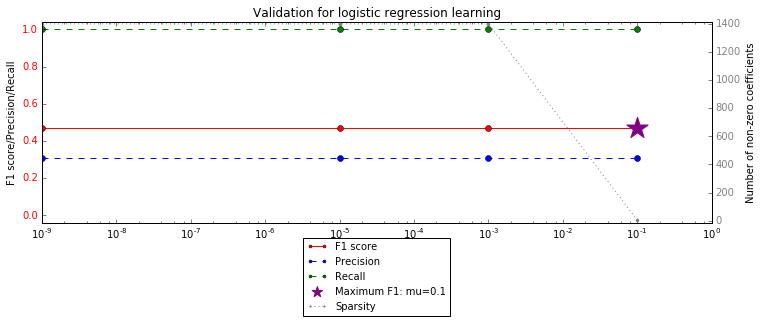

CPU times: user 5.65 s, sys: 976 ms, total: 6.62 s
Wall time: 5.56 s


<ddlite.ModelLog instance at 0x7f80a7529f80>

In [10]:
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)

Calibration and Accuracy

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


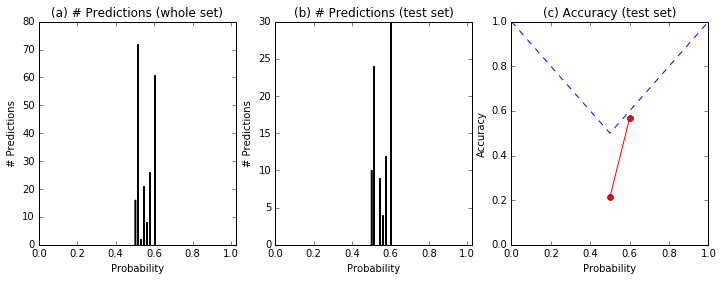

In [11]:
DDL.plot_calibration()

In [12]:
print DDL.holdout()
print DDL.lf_names
print DDL.get_lf_predicted(subset = DDL.holdout())
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
print DDL.get_predicted(subset = DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
print gt
print len(uids)
print len(DDL.get_predicted(subset = DDL.holdout()))
print len(gt)
acc_lfs = np.mean(DDL.get_lf_predicted(subset=DDL.holdout()) == gt)
# DDL.show_log(idx = idxs[0])
print "LF accuracy: {:.3f}\nFull model accuracy: {:.3f}".format(acc_lfs, acc_feats)

[169 189  29 179  81 198 184 133 165 190  23 197 176 132 192  63  42 186
 104 126 188 154 170 196 185 130 167  24  33 158 152 139  83  34  13  32
  68  12 108  17  88  26   0  46  49 193 171  36 195  25 131 175 134  67
 137  69 164 201 205  76  52 135   1 138   8  11  30  86 140  60 203  59
 187  93  74 204  91  90  39 103  44  15   7 183 153 160  61  48  21 172
  70 149 116 119  43 174 177 100 202 148  78 173 106 123  98  87  75 146
  97  14  53 115 117 162  55  22 136 107  38 180  51 199 122  20  99  77
 118   2  82  95  37 141  66 127 200 168 178 102  19 194  71 155 156  31
  56 125  80  35  72  62  16  18 150 166  10 142 109 157 124  45  73  89
 163 191  40  47  50 182  79 111 101  92 147  28  84  85 121]
['LF_alwaysTrue', 'LF_alwaysTrue']
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1